EDA To Prediction (DieTanic)을 보고 필사했습니다. - https://www.kaggle.com/code/ash316/eda-to-prediction-dietanic/notebook

---

> 삶은 때론 잔인한 유머 감각을 가집니다.
> 
> 삶은 당신이 항상 원했던 것을 가장 최악의 시간에 가지게 합니다.

타이타닉의 침몰은 역사 상 가장 악명 높은 난파 중 하나입니다. 

1912년 4월 15일, 타이타닉의 첫번째 항해에서 타이타닉은 빙산과 부딪친 후 가라 앉았는데, 거기서 총 2224명의 승객과 선원 중 1502명이 사망했습니다. 그래서 "DieTanic"이라고도 불리는 이유가 바로 이 때문입니다. 정말 잊을 수 없는 재난이고, 세계 어느 누구도 잊을 수 없습니다. 

타이타닉을 모두 짓는데 750만 달러 가까이 들었고, 충돌 때문에 바다 아래로 가라앉았습니다. 타이타닉 데이터셋은 데이터 사이언스를 탐험하고 Kaggle 경쟁에 참여를 시작하는 초심자에게 매우 좋은 데이터셋입니다.

이 노트북 목적은 모든 예측 모델링 문제의 workflow가 어떤 것인지 아이디어를 제공하는 것입니다. 어떻게 feature들을 체크하고, 어떻게 새로운 features들과 몇몇 머신 러닝 컨셉을 추가하는지. 나는 어떤 초심자도 모든 맥락을 이해할 수 있도록 노트북을 가능한한 기초적으로 하려고 노력해왔습니다. 

만일 당신이 이 노트북을 좋아하고 당신에게 도움을 줬다고 생각한다면, UPVOTE 해주세요. 
이것은 제게 동기를 일으켜줍니다.

# 목차

**Part1: 데이터 분석 탐험(EDA)**

1. feature들을 분석
2.  여러 feature들을 고려해서 어떤 관계, 트랜드가 있는지 찾음

**Part2: Feature 엔지니어링 & 데이터 클린징**

1. feature를 추가
2. 장황한 feature들은 제거
3. 모델에 적합한 형식으로 feature들을 변환

**Part3: 모델로 예측하기**

1. 기본 알고리즘 돌리기
2. Cross Validation
3. Ensembling
4. 중요한 feature 추출



# Part1: 데이터 분석 탐험(EDA)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data = pd.read_csv('/content/drive/MyDrive/colab/data-analysis-practice/data/01_titanic/train.csv')

In [10]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
# 전체에서 null 값이 있는지 확인

data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Age, Cabin, Embarked**가 null 값입니다. 이를 수정할 예정입니다.

### 얼마나 생존했을까?

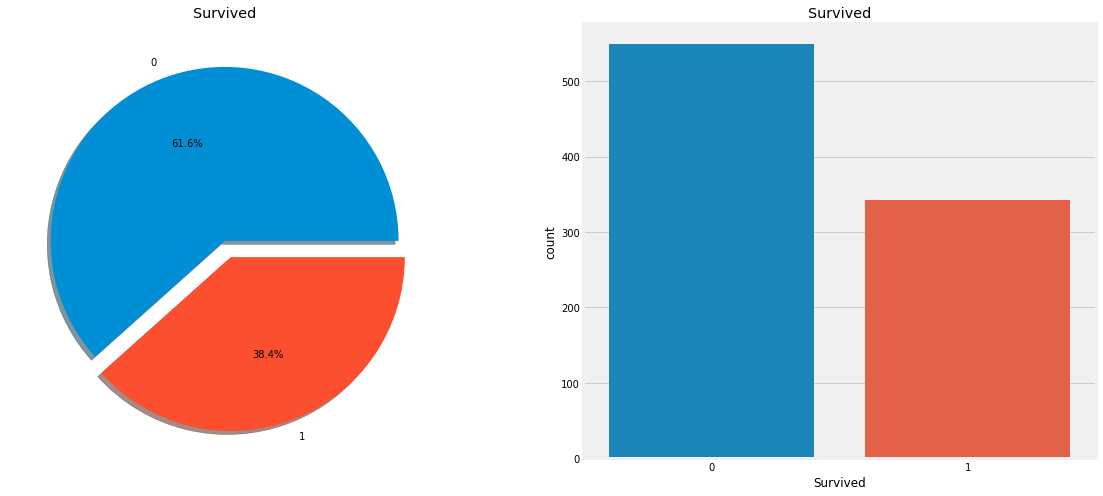

In [12]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

survived = data['Survived'].value_counts()
survived.plot.pie(
    explode=[0, 0.1], 
    autopct='%1.1f%%', 
    ax=ax[0], 
    shadow=True
)

ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data=data, ax=ax[1])
ax[1].set_title('Survived')
plt.show()



drive  sample_data
